# Bibliotecas

In [ ]:
# Manipulação dos dados
import pandas as pd
import numpy as np

# Visualização dos dados
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# Estatística
!pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import acf, pacf

# Erro
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.2 MB/s eta 0:00:00


# Dados


In [ ]:
consumo_21 = [39863, 79189, 95428, 95750, 90762, 97492, 87403, 87609, 104634, 103269, 104045, 98424]  #kWh
consumo_22 = [103132, 97580, 112784, 91888, 97428, 107599, 121757, 150572, 133419, 125440, 130155, 78985]  #kWh
consumo_23 = [121246, 131145, 134613, 117445, 155150, 147951, 138817, 178464, 169721, 173019, 140507, 121532]  #kWh
meses = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez']

# Manipulação e Análise de Dados

In [ ]:
df_consumo = pd.DataFrame({"2021":consumo_21, "2022":consumo_22, "2023":consumo_23})
df_consumo.head()

,2021,2022,2023
0,39863,103132,121246
1,79189,97580,131145
2,95428,112784,134613
3,95750,91888,117445
4,90762,97428,155150


In [ ]:
# Análise descritiva do consumo anual
df_consumo.describe()

,2021,2022,2023
count,12.000000,12.000000,12.000000
mean,90322.333333,112561.583333,144134.166667
std,17631.308683,20363.988141,21000.673772
min,39863.000000,78985.000000,117445.000000
25%,87557.500000,97542.000000,128741.750000
50%,95589.000000,110191.500000,139662.000000
75%,99635.250000,126618.750000,158792.750000
max,104634.000000,150572.000000,178464.000000


In [ ]:
# Gráfico do consumo anual, da energia contratada flat e da flexibilidade (limites)
fig1 = go.Figure()

# Barras do gráfico
fig1.add_trace(go.Bar(x=meses, y=df_consumo["2021"], name='Consumo 2021'))
fig1.add_trace(go.Bar(x=meses, y=df_consumo["2022"], name='Consumo 2022'))
fig1.add_trace(go.Bar(x=meses, y=df_consumo["2023"], name='Consumo 2023'))

# Linhas do gráfico
contrato_flat = 200*720  # KW*h/mês == KWh/mês
fig1.add_trace(go.Scatter(x=meses, y=np.full(len(meses), contrato_flat),
    name='Contrato Flat',
    mode='lines+markers',
    line=dict(color='black')
))
fig1.add_trace(go.Scatter(x=meses, y=np.full(len(meses), contrato_flat*1.40),  # limite superior (flexibilidade +40%)
    name='Limite Superior',
    mode='lines',
    line=dict(dash='dash', color='red')
))
fig1.add_trace(go.Scatter(x=meses, y=np.full(len(meses), contrato_flat*0.00),  # limite inferior (flexibilidade -100%)
    name='Limite Inferior',
    mode='lines',
    line=dict(dash='dash', color='orange')
))
fig1.update_layout(barmode='group',
                  title={'text': "Consumo Anual", 'x': 0.5},
                  title_font=dict(size=20),
                  xaxis_tickangle=-45,
                  yaxis_title="<b>Energia</b> (Wh)")
fig1.show()

In [ ]:
# Série Histórica do Consumo de Energia
ts = consumo_21+consumo_22+consumo_23
df_ts = pd.DataFrame(ts)
df_ts.columns = ["consumo"]

start_date = "2021-01-01"
end_date = "2023-12-31"
df_ts["data"] = pd.date_range(start=start_date, end=end_date, freq="ME")
df_ts.set_index('data', inplace=True)

# Análise descritiva da série histórica
df_ts.describe()

,consumo
count,36.000000
mean,115672.694444
std,29462.285624
min,39863.000000
25%,97008.500000
50%,110191.500000
75%,133717.500000
max,178464.000000


In [ ]:
# Gráfico do histórico de consumo
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df_ts.index, y=df_ts['consumo'], mode='lines'))
fig2.update_layout(title={'text': "Série Histórica", 'x': 0.5},
                  title_font=dict(size=20),
                  xaxis_tickangle=-45,
                  yaxis_title="<b>Energia</b> (Wh)")
fig2.update_xaxes(range=['2021-01-01', '2023-12-31'],
                 dtick="M2")
fig2.show()

# Projeção do Consumo
Projeção do consumo de energia utilizando o modelo **ARIMA** (AutoRegressive Integrated Moving Average).

## ARIMA

### Estacionariedade da Série

In [ ]:
# Teste de Estacionariedade
def stat_test(series_value):
    stat_test = adfuller(series_value)
    test_result = pd.Series(stat_test[0:4], index = ['Estatística do Teste', 'p-value', 'Lags Usadas', 'Nº de Observações'])

    print(test_result)

stat_test(df_ts['consumo'])

Estatística do Teste    -3.150965
p-value                  0.023004
Lags Usadas              0.000000
Nº de Observações       35.000000
dtype: float64


In [ ]:
# Diferenciação de 1º ordem
dif = df_ts['consumo'].diff()
dif.dropna(inplace = True)
stat_test(dif)

Estatística do Teste   -7.424605e+00
p-value                 6.599039e-11
Lags Usadas             0.000000e+00
Nº de Observações       3.400000e+01
dtype: float64


### Parâmetros do Modelo

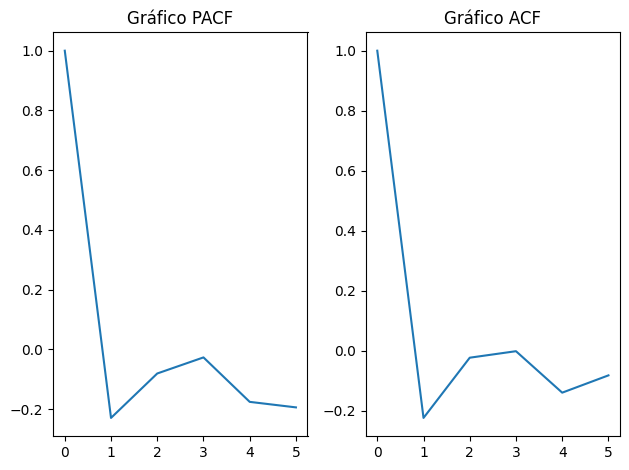

In [ ]:
param_p = pacf(dif, nlags=5)
param_q = acf(dif, nlags=5)

# Plot PACF e ACF
plt.subplot(121)
plt.plot(param_p)
plt.title('Gráfico PACF')

plt.subplot(122)
plt.plot(param_q)
plt.title('Gráfico ACF')

plt.tight_layout()

### Seleção e Ajuste do Modelo
Documentação: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

**Nota:** Volume de dados muito pequeno para validar o modelo divindo duas partes dos dados em treinamento e teste.

In [ ]:
arima_model = auto_arima(df_ts['consumo'],start_p=0,d=1,start_q=0,max_p=2,max_q=2,seasonal=True,m=12,start_P=0,D=1,start_Q=0,max_P=2,max_Q=2,
                            stepwise=True,
                            suppress_warnings=True,
                            error_action='ignore')
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   36
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -261.480
Date:                            Wed, 02 Oct 2024   AIC                            526.961
Time:                                    21:40:01   BIC                            529.232
Sample:                                01-31-2021   HQIC                           527.532
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5912      0.220     -2.692      0.007      -1.021      -0.161
sigma2      3.636e+08   1.02e-10   3.58e+18      0.000    3.64e+08    3.64e+08
===================================================================================
Ljung-Box (L1) (Q):                   3.01   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.08   Prob(JB):                         0.94
Heteroskedasticity (H):               1.41   Skew:                            -0.08
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [ ]:
# Medidas de Erro do modelo ajustado
y_real = df_ts['consumo']  # Valores reais
y_ajus = arima_model.predict_in_sample()  # valores ajusatdos do modelo ARIMA

rmse = sqrt(mean_squared_error(y_real, y_ajus))
print("Raiz do Erro Quadrático Médio (RMSE):", rmse)

mae = mean_absolute_error(y_real, y_ajus)
print(f'Erro Médio Absoluto (MAE): {mae}')

r2 = r2_score(y_real, y_ajus)
print(f'Coeficiente de Determinação (R²): {r2}')

Raiz do Erro Quadrático Médio (RMSE): 19696.143800091475
Erro Médio Absoluto (MAE): 15307.021808378086
Coeficiente de Determinação (R²): 0.5403111200601998


Um R² entre 0.5 e 0.7 não é dos melhores, mas razoável, ainda mais considerando o pequeno volume de dados utilizado para ajustar o modelo.

## Projeção de Consumo
Considerando 2024 como um ano atípico na operação da empresa, que terá um aumento de aproximadamente 30% do consumo de energia em razão da instalação de novos equipamentos, foram criados dois cenários de projeção de consumo. Um cenário sem considerar o aumento de 30%, com uma projeção que segue a tendência do histórico de consumo, e outro considerando o aumento de 30% além do aumento calculado com base no histórico de consumo.

In [ ]:
proj = arima_model.predict(n_periods=12)
proj_aumen = proj*1.3

# Gráfico do consumo e projeção
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=df_ts.index, y=y_real, name="Consumo Real", mode='lines'))
fig3.add_trace(go.Scatter(x=df_ts.index, y=y_ajus, name="Consumo Modelado", mode='lines', line=dict(dash='dash', color='orange')))
fig3.add_trace(go.Scatter(x=proj.index, y=proj, name="Projeção Consumo", mode='lines', line=dict(color='red')))
fig3.add_trace(go.Scatter(x=proj.index, y=proj_aumen, name="Projeção +30%", mode='lines+markers', line=dict(color='red')))
fig3.update_layout(title={'text': "Projeção do Consumo de Energia", 'x': 0.5},
                  title_font=dict(size=20),
                  xaxis_tickangle=-45,
                  yaxis_title="<b>Energia</b> (Wh)")
fig3.update_xaxes(range=['2021-01-01', '2024-12-31'], dtick="M3")
fig3.show()

In [ ]:
# Consumo TOTAL de energia
cons_24 = sum(proj.values).round(2)
print(f'Consumo total de energia em 2024 sem considerar aumento de 30%: {cons_24}kWh')
cons_aumen_24 = sum(proj_aumen.values).round(2)
print(f'Consumo total de energia em 2024 considerando aumento de 30%: {cons_aumen_24}kWh')
print(f'Diferença: {cons_aumen_24-cons_24}kWh')

Consumo total de energia em 2024 sem considerar aumento de 30%: 1878300.89kWh
Consumo total de energia em 2024 considerando aumento de 30%: 2441791.15kWh
Diferença: 563490.26kWh


## Cenários de Consumo
Simular diferentes cenários de projeção do consumo de energia permite entender como variações no perfil de consumo do cliente podem impactar financeiramente o contrato, prevendo possíveis exposições ao PLD (projeção do consumo além dos limites da flexibilidade definida). Foram criados 3 cenários de projeção:

- Otimista: -10% da projeção de consumo
- Conservador: própria projeção de consumo
- Pessimista: +10% da projeção de consumo

### Cenários da Projeção sem Aumento de 30%

In [ ]:
# Gráfico dos cenários de projeção
fig4 = go.Figure()
fig4.add_trace(go.Scatter(x=df_ts.index, y=df_ts['consumo'], mode='lines', name="Consumo Real"))
fig4.add_trace(go.Scatter(x=proj.index, y=proj, mode='lines', name="Projeção Consumo"))
fig4.add_trace(go.Scatter(x=proj.index, y=proj.apply((lambda x: x * (1.1))), mode='lines', line=dict(dash='dash', color='gray', width=1), name="±10% da Projeção"))
fig4.add_trace(go.Scatter(x=proj.index, y=proj.apply((lambda x: x * (0.9))), mode='lines', line=dict(dash='dash', color='gray', width=1), name=""))

fig4.add_trace(go.Scatter(
    x=proj.index.tolist() + proj.index[::-1].tolist(),
    y=(proj * 1.1).tolist() + (proj * 0.9)[::-1].tolist(),
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=False,
    name="Intervalo de Projeção"))

start_date = '2021-01-01'
end_date = '2024-12-31'
index = pd.date_range(start=start_date, end=end_date, freq="ME")

fig4.add_trace(go.Scatter(x=index,y=np.full(len(index),contrato_flat),name='Contrato Flat',mode='lines',line=dict(color='black')))
fig4.add_trace(go.Scatter(x=index,y=np.full(len(index),contrato_flat*1.40),name='Flexibilidade Superior',mode='lines',line=dict(dash='dash', color='red')))
fig4.add_trace(go.Scatter(x=index,y=np.full(len(index),contrato_flat*0.00),name='Flexibilidade Inferior',mode='lines',line=dict(dash='dash', color='orange')))

fig4.update_layout(title={'text': "Cenários do Consumo sem Aumento de 30%", 'x': 0.5},
                  title_font=dict(size=20),
                  xaxis_tickangle=-45,
                  yaxis_title="<b>Energia</b> (Wh)")
fig4.update_xaxes(range=['2021-01-01', '2024-12-31'], dtick="M3")
fig4.show()

Em um cenário pessimista, a partir da projeção de consumo realizada, o cliente consumiria em agosto (212,33kWh) além da flexibilidade (+40%) permitida em contrato, mas se manteria abaixo do limite estabelecido pela flexibilidade nos cenários conservador e otimista.

### Cenários da Projeção com Aumento de 30%

In [ ]:
# Gráfico dos cenários de projeção
fig5 = go.Figure()
fig5.add_trace(go.Scatter(x=df_ts.index, y=df_ts['consumo'], mode='lines', name="Consumo Real"))
fig5.add_trace(go.Scatter(x=proj_aumen.index, y=proj_aumen, mode='lines+markers', name="Projeção +30%"))
fig5.add_trace(go.Scatter(x=proj_aumen.index, y=proj_aumen.apply((lambda x: x * (1.1))), mode='lines', line=dict(dash='dash', color='gray', width=1), name="±10% da Projeção"))
fig5.add_trace(go.Scatter(x=proj_aumen.index, y=proj_aumen.apply((lambda x: x * (0.9))), mode='lines', line=dict(dash='dash', color='gray', width=1), name=""))

fig5.add_trace(go.Scatter(
    x=proj_aumen.index.tolist() + proj_aumen.index[::-1].tolist(),
    y=(proj_aumen * 1.1).tolist() + (proj_aumen * 0.9)[::-1].tolist(),
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=False,
    name="Intervalo de Projeção"))

start_date = '2021-01-01'
end_date = '2024-12-31'
index = pd.date_range(start=start_date, end=end_date, freq="ME")

fig5.add_trace(go.Scatter(x=index,y=np.full(len(index),contrato_flat),name='Contrato Flat',mode='lines',line=dict(color='black')))
fig5.add_trace(go.Scatter(x=index,y=np.full(len(index),contrato_flat*1.40),name='Flexibilidade Superior',mode='lines',line=dict(dash='dash', color='red')))
fig5.add_trace(go.Scatter(x=index,y=np.full(len(index),contrato_flat*0.00),name='Flexibilidade Inferior',mode='lines',line=dict(dash='dash', color='orange')))

fig5.update_layout(title={'text': "Cenários do Consumo com Aumento de 30%", 'x': 0.5},
                  title_font=dict(size=20),
                  xaxis_tickangle=-45,
                  yaxis_title="<b>Energia</b> (Wh)")
fig5.update_xaxes(range=['2021-01-01', '2024-12-31'], dtick="M3")
fig5.show()

Com o aumento de 30% previsto, os 3 cenários simulados ultrapassaram o limite da flexibilidade em alguns dos meses.

# Projeção de Custo

## Projeção de Custo sem Aumento de 30%

In [ ]:
preco24 = 206.08/1000  # preço da energia contratada ajustado para 2024 (R$/KWh)

# Gráfico projeção de custo
fig6 = go.Figure()
fig6.add_trace(go.Scatter(x=meses, y=proj*preco24, name="Projeção Custo", mode='lines', line=dict(color='#006400')))
fig6.add_trace(go.Scatter(x=meses, y=(proj*preco24).apply((lambda x: x * (1.1))), name="±10% da Projeção", mode='lines', line=dict(dash='dash', color='#BA55D3')))
fig6.add_trace(go.Scatter(x=meses, y=(proj*preco24).apply((lambda x: x * (0.9))), name="", mode='lines', line=dict(dash='dash', color='#BA55D3')))
fig6.update_layout(title={'text': "Cenários de Custo sem Aumento de 30% (2024)", 'x': 0.5},
                  title_font=dict(size=20),
                  xaxis_tickangle=-45,
                  yaxis_title="<b>Custo</b> (R$)")
fig6.show()

## Projeção de Custo com Aumento de 30%

In [ ]:
preco24 = 206.08/1000  # preço da energia contratada ajustado (IPCA) para 2024 (R$/KWh)

# Gráfico projeção de custo
fig7 = go.Figure()
fig7.add_trace(go.Scatter(x=meses, y=proj_aumen*preco24, name="Projeção Custo", mode='lines', line=dict(color='#006400')))
fig7.add_trace(go.Scatter(x=meses, y=(proj_aumen*preco24).apply((lambda x: x * (1.1))), name="±10% da Projeção", mode='lines', line=dict(dash='dash', color='#BA55D3')))
fig7.add_trace(go.Scatter(x=meses, y=(proj_aumen*preco24).apply((lambda x: x * (0.9))), name="", mode='lines', line=dict(dash='dash', color='#BA55D3')))
fig7.update_layout(title={'text': "Cenários de Custo com Aumento de 30% (2024)", 'x': 0.5},
                  title_font=dict(size=20),
                  xaxis_tickangle=-45,
                  yaxis_title="<b>Custo</b> (R$)")
fig7.show()

In [ ]:
# Custo TOTAL de energia
cust_24 = sum((proj*preco24).values).round(2)
print(f'Custo total de energia em 2024 sem considerar aumento de 30%: R${cust_24}')
cust_aumen_24 = sum((proj_aumen*preco24).values).round(2)
print(f'Custo total de energia em 2024 considerando aumento de 30%: R${cust_aumen_24}')
print(f'Diferença: R${cust_aumen_24-cust_24}')

Custo total de energia em 2024 sem considerar aumento de 30%: R$387080.25
Custo total de energia em 2024 considerando aumento de 30%: R$503204.32
Diferença: R$116124.07


In [ ]:
# Percentual do aumento de custo comparado a 2023
cust_23 = sum(consumo_23)*(196.23/1000)
percent = ((cust_24/cust_23)*100)-100
percent_aumen = ((cust_aumen_24/cust_23)*100)-100
print(f'Percentual do aumento de custo em 2024 comparado a 2023 (SEM 30% de aumento): {round(percent, 2)}%')
print(f'Percentual do aumento de custo em 2024 comparado a 2023 (COM 30% de aumento): {round(percent_aumen, 2)}%')

Percentual do aumento de custo em 2024 comparado a 2023 (SEM 30% de aumento): 14.05%
Percentual do aumento de custo em 2024 comparado a 2023 (COM 30% de aumento): 48.26%


# Análise de Risco
O risco nesse tipo de operação está principalmente atrelado a posição deficitária de energia consumida com relação a energia contratada, com risco de exposição ao preço da energia no mercado de curto prazo (PLD). A intenção aqui é fornecer ao cliente uma quantificação do risco associado à sua posição de compra de energia no mercado livre. Para isso utiliza-se o Value at Risk (VaR), que serve como uma métrica para tomada de decisão sob incerteza.

**Premissas**
- Diferenças entre a energia consumida e contratada, tanto positivas quanto negativas, ficam expostas ao PLD do mês analisado.
- As projeções de consumo realizadas não fazem parte da análise, o objetivo é avaliar o risco da posição contratual no primeiro trimestre de 2024.

In [ ]:
# PLD mensal subsistema SUL de 01/2021 até 12/23 em R$/MWh
pld_mensal = [240.37,164.4,110.28,136.92,226.16,336.99,583.88,583.88,577.37,249.36,88.1,66.67,62.92,55.7,55.7,55.7,55.7,55.71,66.32,76.9,56.08,55.7,55.7,55.7,69.04,69.04,69.04,69.04,69.04,69.04,69.04,69.04,80.37,74.84,84.4,74.09]
pld_mensal = [x/1000 for x in pld_mensal]  # R$/MWh para R$/kWh

def exposicao(E_contratada, E_consumida, pld):
    lista = []
    for i, val in enumerate(pld):
        exposicao = (E_contratada - E_consumida.iloc[i])*val
        lista.append(exposicao)

    return lista

## Com Flexibilidade
Cálculo do VaR considerando a flexibilidade prevista de +40% do valor contratado flat.

In [ ]:
contrato_flex = (200*1.4)*720  # KWh/mês
exposicao_flex = exposicao(contrato_flex, df_ts['consumo'], pld_mensal)

conf = 95  # Nível de confiança

VaR = np.percentile(exposicao_flex, 100 - conf)  # Value at Risk (VaR)
print(f"VaR{conf}%: {VaR}") # VaR 1 mês
print(f"VaR{conf}% 1º trimestre de 2024: {VaR*np.sqrt(3)}") # VaR do primeiro trimestre 2024

VaR95%: 2456.3369325000003
VaR95% 1º trimestre de 2024: 4254.500367597884


Pode-se afirmar, com 95% de confiança, que a "exposição esperada" desta operação será maior ou igual a R$ 4.254.50 no primeiro trimestre de 2024.

## Sem Flexibilidade
Cálculo do VaR sem considerar a flexibilidade prevista de +40% do valor contratado flat.

In [ ]:
exposicao_flat = exposicao(contrato_flat, df_ts['consumo'], pld_mensal)

conf = 95  # Nível de confiança

VaR = np.percentile(exposicao_flat, 100 - conf) # Value at Risk (VaR)
print(f"VaR{conf}%: {VaR}")
print(f"VaR{conf}% 1º trimestre de 2024: {VaR*np.sqrt(3)}") # VaR do primeiro trimestre 2024

VaR95%: -2093.3430675000004
VaR95% 1º trimestre de 2024: -3625.776550582086


Pode-se afirmar, com 95% de confiança, que a "exposição esperada" desta operação, nesse caso a **perda**, não ultrapassará R$ 3.625.77 no primeiro trimestre de 2024. A análise evidência como a flexibilidade do contrato tem forte impacto sobre o risco associado a operação em questão, mostrando que não há perdas no caso “com flexibilidade”.

In [ ]:
# Quantis
quantis = np.percentile(exposicao_flat, np.arange(0, 101, 1))

fig8 = go.Figure()
fig8.add_trace(go.Scatter(x=np.arange(0, 101, 1), y=quantis, name='Quantis', mode='lines+markers', line=dict(color='#B8860B')))
fig8.add_trace(go.Scatter(x=[0, 100], y=[VaR, VaR], name=f'VaR{conf}%', mode='lines', line=dict(dash='dash', color='red')))
fig8.update_layout(title={'text': "Curva de Quantis da Exposição Esperada", 'x': 0.5},
                   title_font=dict(size=20),
                   xaxis_title="<b>Probabilidade Acumulada</b> (%)",
                   yaxis_title="<b>Quantil</b> (R$)",
                   yaxis=dict(tickmode='array', tickvals=np.linspace(np.min(exposicao_flat), np.max(exposicao_flat), num=10)),
                   showlegend=True)
fig8.show()

Para garantir o adequado planejamento do consumo de energia e custos considerando uma expansão da operação para o próximo ano, recomenda-se:
- Calcular a potência dos eventuais equipamentos que farão parte da expansão operacional, e seus respectivos tempos médios em operação, isso dará uma noção do consumo médio de energia acrescido.
- Incluir o consumo adicional na análise da projeção para o próximo ano, como elaborado no presente documento.
- Avaliar o risco da operação de compra de energia no mercado livre também é uma boa prática de planejar possíveis gastos.